# Cargar los datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tslearn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam

In [5]:
data = arff.loadarff("/content/drive/MyDrive/MasterKISA/ITSDA/Entrega2/MoteStrain.arff")
df = pd.DataFrame(data[0])

print(df.head())

       att1      att2      att3      att4      att5      att6      att7  \
0  0.398150  0.503921  0.525904  0.607302  0.572887  0.804101  0.721741   
1 -1.094367 -1.251307 -1.417703 -1.501493 -1.354483 -1.193750 -1.036556   
2  0.081700  0.057580  0.019309 -0.017998 -0.045013 -0.058199 -0.122842   
3 -1.425477 -1.451659 -1.486758 -1.535277 -1.558609 -1.582891 -1.620021   
4 -0.500857 -0.529616 -0.569820 -0.624989 -0.678105 -0.712733 -0.744573   

       att8      att9     att10  ...     att76     att77     att78     att79  \
0  0.688301 -0.419047 -0.853946  ... -0.105779  0.020968  0.108770  0.130787   
1 -0.804107 -0.760073 -0.489427  ... -0.716078 -0.635516 -0.431121 -0.254227   
2 -0.421939 -0.412290 -0.304506  ... -0.385918  0.025096  0.192977  0.221922   
3 -1.602121 -1.518666 -1.331724  ... -0.900335  0.190807  0.708513  0.192089   
4 -0.769077 -0.799596 -0.822486  ... -0.793140 -0.799009  0.200505  0.513916   

      att80     att81     att82     att83     att84  target  
0  0.1

In [6]:
clases = df.iloc[:, -1]
clases.value_counts()

,count
target,
b'1',685
b'2',587


Hay 1272 instancias, de las cuales 685 son de la clase 1 () y 587 son de la clase 2 ().

Para hacer el split de train test, dividir en la proporcion 80, 20 los datos de manera stratified.

In [7]:
X = df.drop(columns=['target']).values
y = pd.Categorical(df['target']).codes

X = X.reshape(X.shape[0], X.shape[1], 1)
# División estratificada en 80% para entrenamiento y 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar las proporciones
print("Distribución en y_train:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nDistribución en y_test:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribución en y_train:
0    0.53884
1    0.46116
Name: proportion, dtype: float64

Distribución en y_test:
0    0.537255
1    0.462745
Name: proportion, dtype: float64


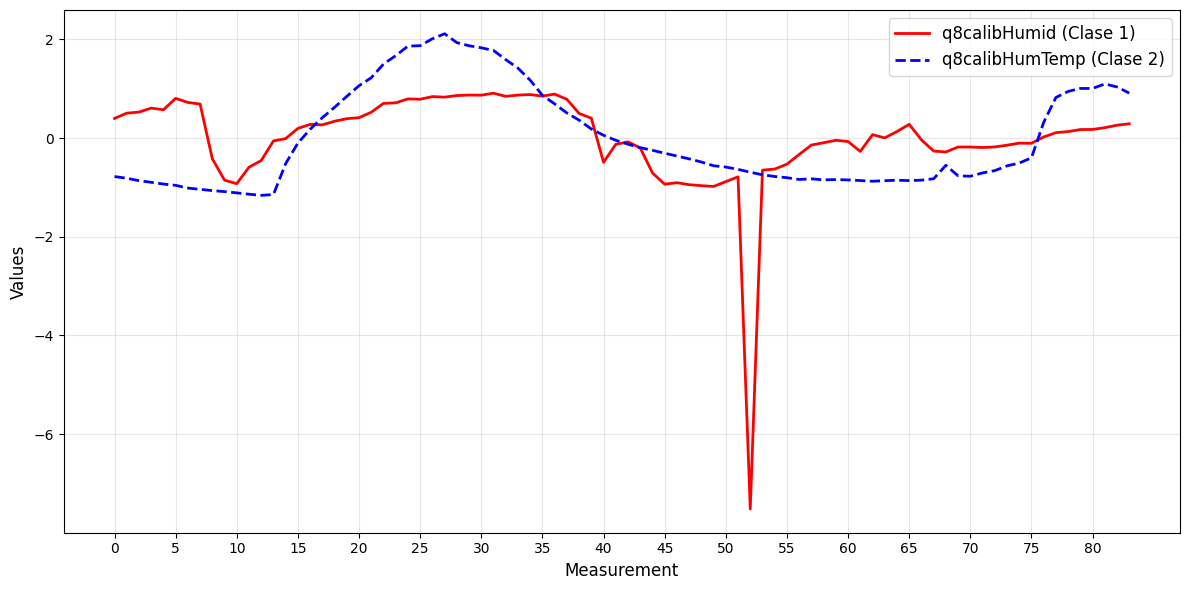

In [10]:
# Extraer la primera fila y los nombres de las columnas
row0 = df.iloc[0]
row1 = df.iloc[400]
class_label0 = row0.iloc[-1]  # Última columna (la clase)
values0 = row0.iloc[:-1]  # Todas las columnas excepto la última
class_label1 = row1.iloc[-1]  # Última columna (la clase)
values1 = row1.iloc[:-1]  # Todas las columnas excepto la última

# Crear el gráfico
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
plt.plot(values0, color='red', label="q8calibHumid (Clase 1)", linewidth=2, linestyle='-')
plt.plot(values1, color='blue', label="q8calibHumTemp (Clase 2)", linewidth=2, linestyle='--')

# Configurar etiquetas del eje X
ticks = range(0, len(values0), 5)  # Crear ticks de 5 en 5
plt.xticks(ticks, labels=ticks, fontsize=10)  # Etiquetas de ticks de 5 en 5

# Añadir título y etiquetas
plt.xlabel("Measurement", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Añadir leyenda y cuadrícula
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# 1-NN

In [ ]:
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_dtw.fit(X_train, y_train)

# Realizar predicciones
y_pred = knn_dtw.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9568627450980393

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       137
           1       0.97      0.94      0.95       118

    accuracy                           0.96       255
   macro avg       0.96      0.96      0.96       255
weighted avg       0.96      0.96      0.96       255



# Shapelets

In [ ]:
n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], n_classes=len(np.unique(y_train)), l=0.1, r=1
)

shapelet_model = ShapeletModel(n_shapelets_per_size=n_shapelets_per_size,
                               optimizer=Adam(learning_rate=0.05),
                               weight_regularizer=0.01,
                               max_iter=200)

shapelet_model.fit(X_train, y_train)

y_pred = shapelet_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Accuracy: 0.8470588235294118

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       137
           1       0.83      0.84      0.84       118

    accuracy                           0.85       255
   macro avg       0.85      0.85      0.85       255
weighted avg       0.85      0.85      0.85       255

